# SNLO: Waveguides Tutorial

We start with the usual imports and definitions.

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt

import snlo.pulses as pulses
import snlo.materials as materials
import snlo.waveguides as waveguides

from scipy.constants import pi, c, epsilon_0
nm = 1e-9
um = 1e-6
mm = 1e-3
ps = 1e-12
fs = 1e-15
MHz = 1e6
GHz = 1e9
THz = 1e12
pJ = 1e-12
fJ = 1e-15
mW = 1e-3

#Larger font for plots
plt.rcParams.update({'font.size': 18})

## Time/Frequency Grids
We did this in a previous notebook.

In [2]:
#Let's set the bandwdith
λ_start = 800*nm
λ_stop = 3*um
f_max = c/λ_start
f_min = c/λ_stop
BW = f_max - f_min

N = 2**10 #I usually pick this one to be a power of 2 but that's not strictly necessary

T = N/BW #Time window size
Δt = 1/BW #Time resolution
t_start = -T/2 #Start of time window
#These are the time and frequency vectors 
t = t_start + np.arange(0, T, step=Δt)
f = fftfreq(N, Δt)
Ω = 2*pi*f

f_ref = (f_max + f_min)/2  #This variable will be supplied to several plotting functions
f_abs = f + f_ref #This is the absolute frequency vector
λ = c/f_abs #This is the wavelength vector

# Waveguide

<html>
  <body>
    <img src="Waveguide_geometry.png" alt="Waveguide Geometry" width="40%">
  </body>
</html>

In [3]:
width = 1800*nm
hLN = 700*nm
hetch = 350*nm

wg = waveguides.waveguide(w_top=width, h_ridge=hLN, h_slab=hLN-hetch, tf_material = 'LN_MgO_e',
                         box_material = 'SiO2',  clad_material = 'Air')

That's it, we have create a waveguide!

Now we can calculate the refractive index at the wavelengths of interest.
Let's also calculate a poling period for SHG between 2um and 1um.

Refractive index at fundamental = 1.872
Refractive index at second harmonic = 2.065
Poling period for second harmonic generation starting at 1.000 um = 5.1792 um


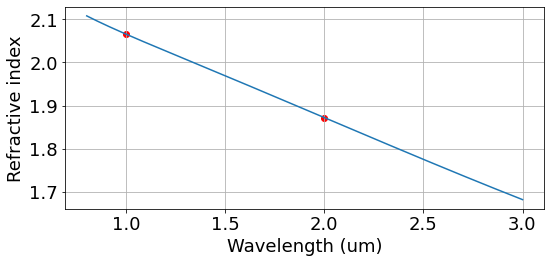

In [4]:
λ1 = 1*um
λ2 = 2*um

n = wg.neff(λ) #This calculates the refractive index at all wavelengths
n1 = wg.neff( λ1 )
n2 = wg.neff( λ2 )

fig, ax1 = plt.subplots(figsize=(8,4), tight_layout=True)
ax1.plot(fftshift(λ/um), fftshift(n))
ax1.scatter( λ1/um, n1, c='r')
ax1.scatter( λ2/um, n2, c='r')
ax1.set_xlabel('Wavelength (um)')
ax1.set_ylabel('Refractive index')
ax1.grid(True)

print('Refractive index at fundamental = %0.3f' %(n2))
print('Refractive index at second harmonic = %0.3f' %(n1))
pp = λ1/(n1-n2)
print("Poling period for second harmonic generation starting at %0.3f um = %0.4f um" %(λ1/um, pp/um))

You also probably want to look at higher order dispersion terms.

In [5]:
gvm_shg = wg.beta1(λ1) - wg.beta1(λ2)
print('GVM between %0.1f nm and %0.1f nm = %0.4f fs/mm' %(λ2/nm, λ1/nm, gvm_shg/(fs/mm)) ) 

print('GVD at %0.1f nm = %0.1f fs^2/mm' %(λ2/nm, wg.GVD(λ2)/(fs**2/mm) ) )
print('GVD at %0.1f nm = %0.1f fs^2/mm' %(λ1/nm, wg.GVD(λ1)/(fs**2/mm) ) )

GVM between 2000.0 nm and 1000.0 nm = 13.2744 fs/mm
GVD at 2000.0 nm = -11.2 fs^2/mm
GVD at 1000.0 nm = 143.2 fs^2/mm


Of course, we can also do it for all wavelengths ( These take a bit longer to calculate):

In [6]:
β1 = wg.beta1(λ)
β2 = wg.beta2(λ)

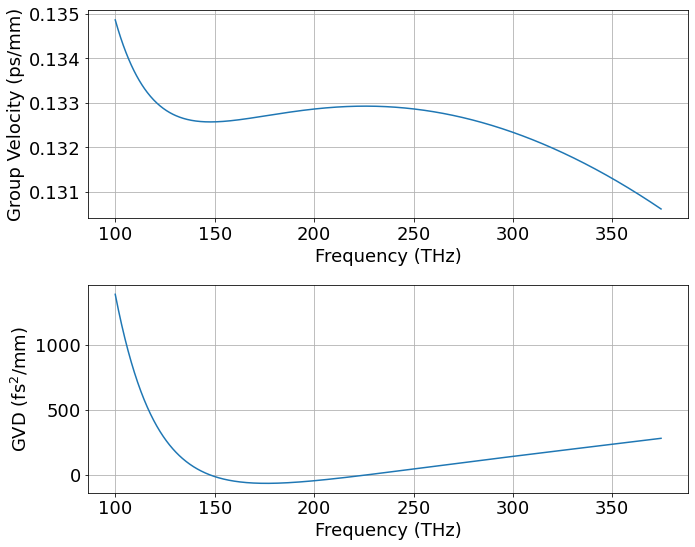

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), tight_layout=True)

ax1.plot(fftshift(f_abs)/THz, fftshift(1/β1)/(mm/ps));
ax1.set_ylabel('Group Velocity (ps/mm)'); ax1.set_xlabel('Frequency (THz)');

ax2.plot(fftshift(f_abs)/THz, fftshift(β2)/(fs**2/mm));
ax2.set_ylabel('GVD (fs$^2$/mm)'); ax2.set_xlabel('Frequency (THz)');

ax1.grid(True); ax2.grid(True);

## Dispersion Engineering

Let's sweep the geometry (wdith and etch) and plot GVM between 1um and 2um.

Text(0.5, 1.0, 'GVM between 2.0um and 1.0um \n h = 700 nm')

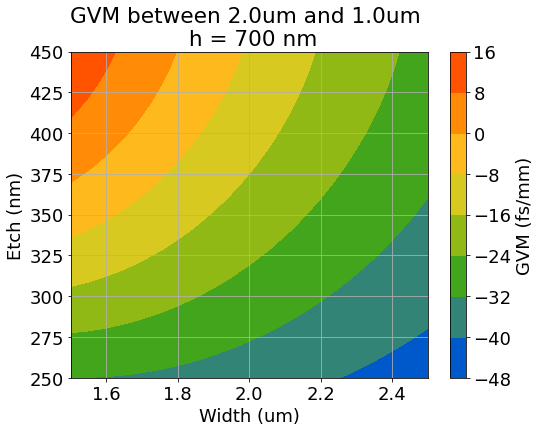

In [8]:
import colorcet as cc #Just 'cause I like the colors

hLN = 700*nm
width = np.arange(1.5*um, 2.5*um+1*nm, 50*nm)
etch = np.arange(250*nm, 450*nm+1*nm, 10*nm)

GVM = np.zeros([width.size, etch.size])
for ke in range(etch.size):
    for kw in range(width.size):
        wg = waveguides.waveguide(w_top=width[kw], h_ridge=hLN, h_slab=hLN-etch[ke])
        GVM[kw, ke] = wg.beta1(λ2) - wg.beta1(λ1)

#Plotting
plt.rcParams['figure.figsize'] = [8, 6]
X,Y = np.meshgrid(width/um, etch/nm)
fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.contourf(X, Y, (np.transpose(GVM/(fs/mm))), cmap = cc.cm["rainbow"])
ax.grid(True)
cb = plt.colorbar(im, ax=ax);
cb.set_label('GVM (fs/mm)')
plt.xlabel('Width (um)')
plt.ylabel('Etch (nm)')

plt.title('GVM between %0.1fum and %0.1fum \n h = %0.0f nm' %(λ2/um, λ1/um, hLN/nm) )

## Adding the rest

Before we run a nonlinear simulation we need to add the nonlinear coefficients, poling, etc.

In [9]:
L = 4*mm #Waveguide length
Alpha = 0.1 # attentuation coefficient (dB/cm)
alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m

def poling_func(z):
    return np.sign(np.cos(z*2*pi/pp))

#Here's where we actually "load" these to the waveguide
wg.add_poling(poling_func)
wg.set_nonlinear_coeffs(N = 1, X0 = 1.1e-12)
wg.set_length(L)
wg.set_loss(alpha)

This is it. The last step is to actually run the nonlinear simulation and we'll do that in the next notebook.